# CNN-GRU

```zsh
pipenv --python 3.11
pipenv install ipykernel==6.28.0 python-dotenv==1.0.0 torch torchvision torchinfo
```

## Imports

In [28]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchinfo import summary
import os
import numpy as np
import json
import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from datetime import datetime
import torch.onnx
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import re

## Load Dataset

In [2]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### My data

In [33]:
# Get a list of all txt files in ./data-gen/data/ and its subdirectories
txt_files = glob.glob('../data-gen/data/**/*.txt', recursive=True)

for txt_file in txt_files:
    # Open the txt file and load the data
    with open(txt_file, 'r') as f:
        data = json.load(f)
    
    # Transform the data
    transformed_data = []
    for array in data:
        transformed_array = []
        for obj in array:
            transformed_array.append([obj['x'], obj['y'], obj['z']])
        transformed_data.append(transformed_array)
    
    # print(txt_file)
    # print(np.array(transformed_data).shape)

    # Create the new json file path
    json_file = os.path.splitext(txt_file)[0] + '.json'

    # Write the transformed data to the new json file
    with open(json_file, 'w') as f:
        json.dump(transformed_data, f)

In [34]:
# Assuming 'data' is your root directory containing all the data folders
root_dir = '../../data-gen/data/'
total_samples = 0

# Iterate over all folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the path is indeed a folder
    if os.path.isdir(folder_path):
        # Count the number of json files in the folder
        num_files = len(glob.glob(os.path.join(folder_path, '*.json')))
        total_samples += num_files

print(f"Total number of samples: {total_samples}")

Total number of samples: 420


(60, 21, 3) ==> (1260, 3) ==> (3, 1260)

In [77]:
batch_size=64

class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(labels)

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            for i, frame in enumerate(data_list):
                if len(frame) != 21:  # Check if each frame has 21 landmarks
                    print(f"Unexpected frame length in file {self.files[idx]} at frame {i}: {len(frame)}")
            data = torch.tensor(data_list)
            data = data.view(-1, 3)  # Flatten the data into (1260, 3)
            data = data.transpose(0, 1)  # Transpose to get (3, 1260)
        label = torch.tensor(self.labels[idx])
        return data, label

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob('../../data-gen/data/**/*.json', recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Split data into train and test sets
train_files, val_files, train_labels, val_labels = train_test_split(json_files, labels, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = LandmarkDataset(train_files, train_labels)
val_dataset = LandmarkDataset(val_files, val_labels)

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [78]:
# get one batch of data
count = 0
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    count += 1
    print(count)


torch.Size([64, 3, 1260])
torch.Size([64])
1
torch.Size([64, 3, 1260])
torch.Size([64])
2
torch.Size([64, 3, 1260])
torch.Size([64])
3
torch.Size([64, 3, 1260])
torch.Size([64])
4
torch.Size([24, 3, 1260])
torch.Size([24])
5


In [79]:
for data, labels in train_loader:
  print(data[0][0].shape)
  print(labels[0].item())
  # Get original labels
  original_labels = train_dataset.encoder.inverse_transform(labels)
  print(original_labels)

torch.Size([1260])
2
['i' 'c' 'i' 'g' 'g' 'j' 'g' 'n' 'g' 'n' 'n' 'n' 'c' 'n' 'c' 'c' 'n' 'z'
 'g' 'j' 'c' 'j' 'g' 'z' 'm' 'm' 'g' 'z' 'n' 'n' 'n' 'j' 'i' 'z' 'm' 'm'
 'g' 'm' 'm' 'z' 'g' 'g' 'i' 'c' 'm' 'j' 'n' 'm' 'm' 'n' 'm' 'j' 'z' 'j'
 'i' 'i' 'c' 'c' 'm' 'n' 'i' 'g' 'j' 'i']
torch.Size([1260])
2
['i' 'j' 'j' 'j' 'j' 'm' 'j' 'z' 'j' 'i' 'i' 'j' 'c' 'm' 'c' 'z' 'i' 'i'
 'c' 'z' 'g' 'g' 'z' 'g' 'c' 'm' 'g' 'm' 'i' 'c' 'j' 'i' 'z' 'g' 'z' 'i'
 'm' 'g' 'm' 'c' 'n' 'm' 'c' 'c' 'c' 'z' 'g' 'c' 'z' 'n' 'z' 'i' 'j' 'g'
 'g' 'g' 'z' 'c' 'c' 'm' 'n' 'i' 'n' 'j']
torch.Size([1260])
1
['g' 'g' 'c' 'i' 'c' 'g' 'j' 'j' 'm' 'i' 'j' 'j' 'm' 'g' 'c' 'z' 'z' 'm'
 'z' 'i' 'i' 'c' 'i' 'g' 'm' 'z' 'm' 'i' 'i' 'n' 'z' 'c' 'z' 'i' 'z' 'c'
 'c' 'g' 'g' 'z' 'g' 'n' 'm' 'i' 'z' 'i' 'i' 'c' 'n' 'c' 'n' 'n' 'n' 'm'
 'j' 'n' 'z' 'g' 'j' 'n' 'n' 'm' 'i' 'j']
torch.Size([1260])
5
['n' 'c' 'm' 'g' 'm' 'm' 'i' 'c' 'i' 'm' 'c' 'j' 'i' 'z' 'c' 'z' 'j' 'n'
 'c' 'g' 'i' 'g' 'm' 'j' 'z' 'n' 'c' 'm' 'c' 'n' 'n' 'n' 'z'

### Interpolated data

In [11]:
def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else float('inf')

class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir, labels, target_frames=60):
        self.root_dir = root_dir
        self.labels = labels
        self.target_frames = target_frames
        self.data = []
        self.load_data()

    def load_data(self):
        for label in self.labels:
            label_dir = os.path.join(self.root_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for capture_folder in os.listdir(label_dir):
                capture_dir = os.path.join(label_dir, capture_folder)
                if os.path.isdir(capture_dir):
                    frames = self.load_and_interpolate_frames(capture_dir)
                    if frames is not None:
                        self.data.append((frames, label))

    def load_and_interpolate_frames(self, capture_dir):
        # List all .txt files in the capture_dir, sort them numerically using numerical_sort
        frame_files = sorted([os.path.join(capture_dir, f) for f in os.listdir(capture_dir) if f.endswith('.txt')], key=numerical_sort)
        
        # If no frame files are found, return None
        if len(frame_files) == 0:
            return None

        frames = []  # Initialize an empty list to hold frames

        # Iterate over each frame file
        for frame_file in frame_files:
            with open(frame_file, 'r') as file:  # Open the frame file for reading
                landmarks = []  # Initialize an empty list to hold landmarks for the current frame
                for line in file:  # Read each line in the file
                    # Convert each line of text into a list of floats and append to landmarks
                    landmarks.append(list(map(float, line.strip().split())))
                # Append the landmarks for the current frame to the frames list
                # Uncomment the next line if you want to flatten the landmarks
                frames.append(landmarks)

        # if the parent folder of the capture_dir is 'A', print shape of frames
        # if os.path.basename(os.path.dirname(capture_dir)) == 'A':
        #     print(np.array(frames).shape)

        # Convert the frames list to a NumPy array
        frames = np.array(frames)
        original_frames = frames.shape[0]  # Get the number of frames in the frames array
        
        # If the number of original frames matches the target number of frames, return the frames as-is
        if original_frames == self.target_frames:
            return frames
        else:
            # Otherwise, interpolate the frames to match the target number of frames
            x = np.linspace(0, 1, original_frames)  # Create a linear space of original frame indices
            x_new = np.linspace(0, 1, self.target_frames)  # Create a linear space of target frame indices
            
            # Perform cubic interpolation along the frame axis
            interpolated_frames = interp1d(x, frames, kind='cubic', axis=0)(x_new)

            # if os.path.basename(os.path.dirname(capture_dir)) == 'A':
            #     print(np.array(interpolated_frames).shape)
            
            # Return the interpolated frames
            return interpolated_frames


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames, label = self.data[idx]
        frames = torch.tensor(frames, dtype=torch.float32)
        # print the shape of frames if the label is 'A'
        if os.path.basename(os.path.dirname(self.root_dir)) == 'A':
            print(np.array(frames).shape)
        frames = frames.view(-1, 3).transpose(0, 1)  # Reshape to (1260, 3) and transpose to (3, 1260)
        if os.path.basename(os.path.dirname(self.root_dir)) == 'A':
            print(np.array(frames).shape)
        label_idx = self.labels.index(label)
        return frames, label_idx

def collate_fn(batch):
    frames = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    frames = torch.stack(frames)
    labels = torch.tensor(labels)
    return frames, labels

# Parameters
root_dir = '../../Jesus-data/downloads'
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Add any other labels if needed
batch_size = 64

# Create dataset and data loader
dataset = HandLandmarkDataset(root_dir, labels)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Example usage
for batch in data_loader:
    inputs, targets = batch
    print(inputs.shape)  # Should be (batch_size, 60, 63)
    print(targets.shape)  # Should be (batch_size,)
    # Further processing...



torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([64, 3, 1260])
torch.Size([64])
torch.Size([4, 3, 1260])
torch.Size([4])


### Concatenated Data

In [13]:
# Define the numerical sort function
def numerical_sort(value):
    import re
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else float('inf')

# Define the LandmarkDataset class
class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform([label.upper() for label in labels])

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            data = torch.tensor(data_list).view(-1, 3).transpose(0, 1)
        label = torch.tensor(self.labels[idx])
        return data, label

# Define the HandLandmarkDataset class
class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir, labels, target_frames=60):
        self.root_dir = root_dir
        self.labels = [label.upper() for label in labels]  # Convert labels to uppercase
        self.target_frames = target_frames
        self.data = []
        self.load_data()

    def load_data(self):
        for label in self.labels:
            label_dir = os.path.join(self.root_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for capture_folder in os.listdir(label_dir):
                capture_dir = os.path.join(label_dir, capture_folder)
                if os.path.isdir(capture_dir):
                    frames = self.load_and_interpolate_frames(capture_dir)
                    if frames is not None:
                        self.data.append((frames, label))

    def load_and_interpolate_frames(self, capture_dir):
        frame_files = sorted([os.path.join(capture_dir, f) for f in os.listdir(capture_dir) if f.endswith('.txt')], key=numerical_sort)
        if len(frame_files) == 0:
            return None

        frames = []
        for frame_file in frame_files:
            with open(frame_file, 'r') as file:
                landmarks = [list(map(float, line.strip().split())) for line in file]
                frames.append(landmarks)

        frames = np.array(frames)
        original_frames = frames.shape[0]
        if original_frames == self.target_frames:
            return frames
        else:
            x = np.linspace(0, 1, original_frames)
            x_new = np.linspace(0, 1, self.target_frames)
            return interp1d(x, frames, kind='cubic', axis=0)(x_new)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames, label = self.data[idx]
        frames = torch.tensor(frames, dtype=torch.float32).view(-1, 3).transpose(0, 1)
        label_idx = self.labels.index(label)
        return frames, label_idx

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return data, labels

# Load json files and their labels
json_files = glob.glob('../../data-gen/data/**/*.json', recursive=True)
labels = [os.path.basename(os.path.dirname(file)).upper() for file in json_files]  # Convert labels to uppercase

# Create LandmarkDataset
landmark_dataset = LandmarkDataset(json_files, labels)

# Define root directory and labels for HandLandmarkDataset
root_dir = '../../Jesus-data/downloads'
hand_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

# Create HandLandmarkDataset
hand_dataset = HandLandmarkDataset(root_dir, hand_labels)

# Combine both datasets
combined_dataset = torch.utils.data.ConcatDataset([landmark_dataset, hand_dataset])

# Split the combined dataset into train and validation sets using train_test_split
combined_size = len(combined_dataset)
indices = list(range(combined_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

batch_size = 64
train_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)
val_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_fn)

# Get one batch of data
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    break


torch.Size([64, 3, 1260])
torch.Size([64])


## Model Set Up

```txt
Model
├── Input Layer
│   └── Conv1D
│       └── MaxPooling1D
│           └── Flatten
│               └── Dense
│                   ├── Concatenate (Final Layer)
│                   └── Reshape
│                       └── GRU
│                           └── GRU_1
│                               └── Dense_1
│                                   └── Concatenate (Final Layer)
``` 
PyTorch's Conv1D layer expects input in the form (batch_size, num_channels, length). In your case, you can consider each coordinate as a channel. So, your input to the Conv1D layer would be (batch_size, 3, 1260), where 1260 is the product of 60 (frames) and 21 (landmarks).

(60, 21, 3) ==> (1260, 3) ==> (3, 1260) ==> (batch_size, 3, 1260)

In PyTorch, it's common to leave out the softmax activation function in the model and instead use the nn.CrossEntropyLoss loss function during training, which applies the softmax function internally. Then, when making predictions, you can apply the softmax function to the model's outputs to get probabilities.

In [14]:
class CNN_GRU_Model(nn.Module):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=3)
        self.maxpooling1d = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(40256, 64)  # Adjust this based on the output of the previous layer
        self.gru = nn.GRU(64, 100, batch_first=True)
        self.gru_1 = nn.GRU(100, 100, batch_first=True)
        self.dense_1 = nn.Linear(100, 64)
        self.final_dense = nn.Linear(128, 26)  # Final Dense layer for 26 classes

    def forward(self, x):
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.flatten(x)
        dense_output = self.dense(x)
        x = dense_output.view(dense_output.shape[0], 1, -1)
        x, _ = self.gru(x)
        x, _ = self.gru_1(x)
        x = self.dense_1(x[:, -1, :])
        x = torch.cat((dense_output, x), dim=1)
        x = self.final_dense(x)
        return x

# Instantiate the model
model = CNN_GRU_Model().to(device)

# Print model summary
print(summary(model, input_size=(batch_size, 3, 1260)))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_GRU_Model                            [64, 26]                  --
├─Conv1d: 1-1                            [64, 64, 1258]            640
├─MaxPool1d: 1-2                         [64, 64, 629]             --
├─Flatten: 1-3                           [64, 40256]               --
├─Linear: 1-4                            [64, 64]                  2,576,448
├─GRU: 1-5                               [64, 1, 100]              49,800
├─GRU: 1-6                               [64, 1, 100]              60,600
├─Linear: 1-7                            [64, 64]                  6,464
├─Linear: 1-8                            [64, 26]                  3,354
Total params: 2,697,306
Trainable params: 2,697,306
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 224.11
Input size (MB): 0.97
Forward/backward pass size (MB): 41.40
Params size (MB): 10.79
Estimated Total Size (MB): 53.16


## Training

In [15]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: rik0. Use `wandb login --relogin` to force relogin


True

In [16]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    # Set model to evaluation mode
    model.eval()
    # Disable gradient calculation (unnecessary for inference)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [17]:
now = datetime.now()  # current date and time
run_time = now.strftime("%Y-%m-%d_%H-%M-%S")
run = wandb.init(project="sign_language", name=f"CNN-GRU_{run_time}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40

train_accuracies = []
val_accuracies = []
losses = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Iterate over data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Log loss to WandB
        wandb.log({"train_loss": loss.item()})

    train_accuracy = calculate_accuracy(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Log train accuracy to WandB
    wandb.log({"train_accuracy": train_accuracy})

    # Evaluate on validation set
    val_accuracy = calculate_accuracy(val_loader)
    val_accuracies.append(val_accuracy)
    
    # Log validation accuracy to WandB
    wandb.log({"val_accuracy": val_accuracy})
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation accuracy: {val_accuracy}%")

# Optionally, log final metrics after training completes
wandb.log({"final_train_accuracy": train_accuracies[-1], "final_val_accuracy": val_accuracies[-1]})


Epoch 1/40, Validation accuracy: 7.6%
Epoch 2/40, Validation accuracy: 23.6%
Epoch 3/40, Validation accuracy: 31.6%
Epoch 4/40, Validation accuracy: 45.6%
Epoch 5/40, Validation accuracy: 40.0%
Epoch 6/40, Validation accuracy: 39.2%
Epoch 7/40, Validation accuracy: 54.8%
Epoch 8/40, Validation accuracy: 59.2%
Epoch 9/40, Validation accuracy: 68.0%
Epoch 10/40, Validation accuracy: 64.4%
Epoch 11/40, Validation accuracy: 68.0%
Epoch 12/40, Validation accuracy: 73.6%
Epoch 13/40, Validation accuracy: 81.2%
Epoch 14/40, Validation accuracy: 81.2%
Epoch 15/40, Validation accuracy: 81.2%
Epoch 16/40, Validation accuracy: 90.4%
Epoch 17/40, Validation accuracy: 85.2%
Epoch 18/40, Validation accuracy: 87.6%
Epoch 19/40, Validation accuracy: 90.0%
Epoch 20/40, Validation accuracy: 90.8%
Epoch 21/40, Validation accuracy: 94.0%
Epoch 22/40, Validation accuracy: 92.0%
Epoch 23/40, Validation accuracy: 96.0%
Epoch 24/40, Validation accuracy: 94.0%
Epoch 25/40, Validation accuracy: 94.8%
Epoch 26/4

In [18]:
total_train_accuracies = []
total_val_accuracies = []
total_losses = []

In [19]:
total_train_accuracies += train_accuracies
total_val_accuracies += val_accuracies
total_losses += losses

In [20]:
print(len(total_train_accuracies))
print(len(total_val_accuracies))
print(len(total_losses))
print(len(range(1, len(total_losses) + 1)))

40
40
640
640


## Evaluation

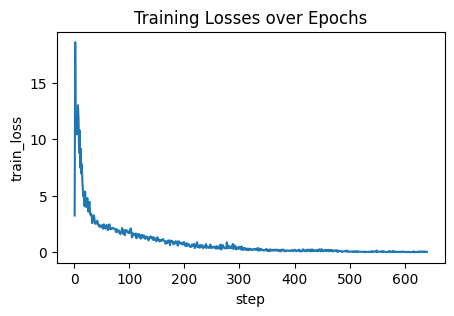

In [21]:
# Create a dataframe
df_loss = pd.DataFrame({
    'step': range(1, len(total_losses) + 1),
    'train_loss': total_losses,
})

# Create lineplot for losses
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_loss, x='step', y='train_loss')
plt.title('Training Losses over Epochs')
plt.show()

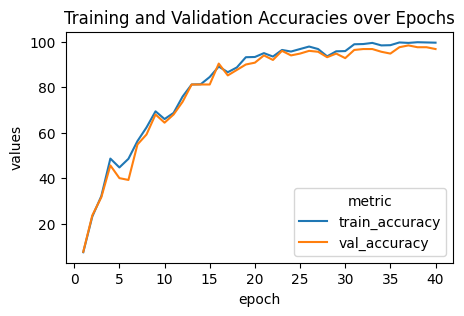

In [22]:
# Create a dataframe
df_acc = pd.DataFrame({
    'epoch': range(1, len(total_train_accuracies) + 1),
    'train_accuracy': total_train_accuracies,
    'val_accuracy': total_val_accuracies
})

# Melt dataframe to long-form for easier plotting
df_acc_melted = df_acc.melt('epoch', var_name='metric', value_name='values')

# Create lineplot for accuracies
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_acc_melted, x='epoch', y='values', hue='metric')
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

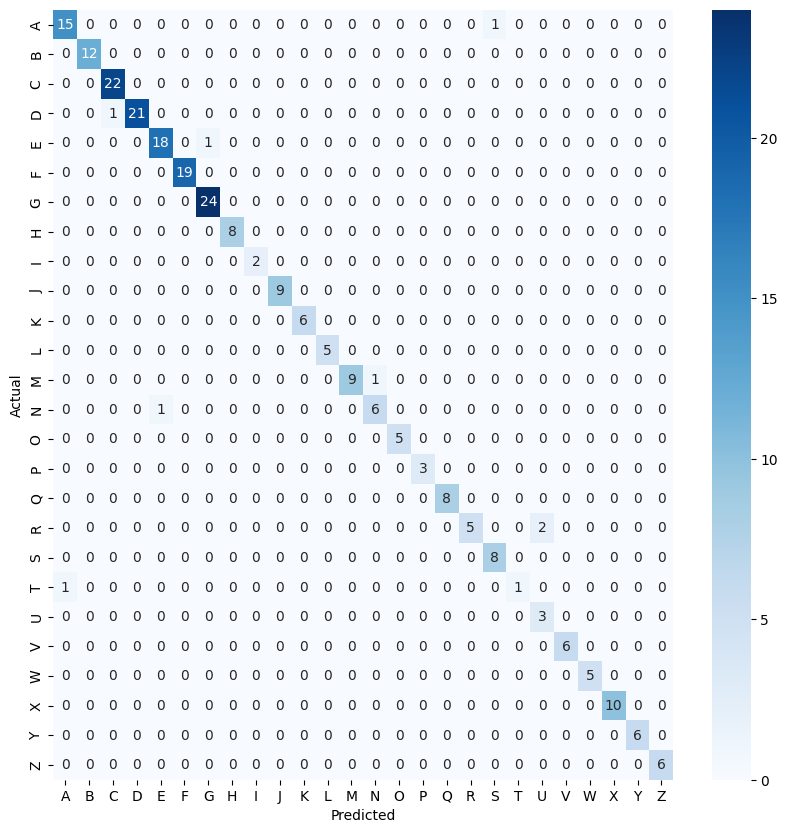

In [25]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get actual labels
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
actual_labels = [alphabets[i] for i in range(26)]

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

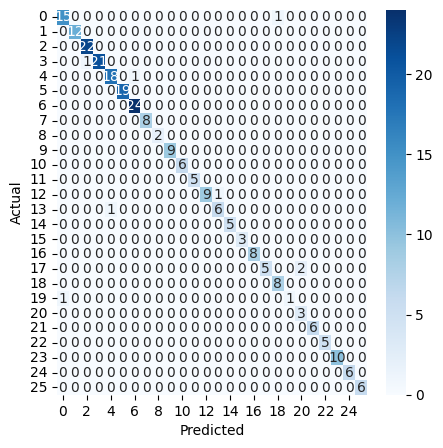

In [26]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# Collect validation features and labels
X_val = []
y_val = []

for data in val_loader:
    inputs, labels = data
    X_val.extend(inputs.numpy())  # Assuming inputs is a Tensor
    y_val.extend(labels.numpy())  # Assuming labels is a Tensor

X_val = torch.tensor(X_val).to(device)
y_val = torch.tensor(y_val).to(device)

# Use your model to predict and evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_val)
    y_pred = y_pred.argmax(dim=1)

# Move y_val and y_pred back to CPU for evaluation
y_val = y_val.cpu()
y_pred = y_pred.cpu()

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted') # 'weighted' accounts for label imbalance
f1 = f1_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

Accuracy: 0.968
Precision: 0.9719783574879227
F1 Score: 0.9677177997106635
Recall: 0.968


In [30]:
torch.save(model, 'model.pth')

In [31]:
wandb.save("model.pth")
run.finish()

final_train_accuracy,▁
final_val_accuracy,▁
train_accuracy,▁▂▃▄▄▄▅▅▆▅▆▆▇▇▇▇▇▇▇█████████████████████
train_loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▃▃▅▅▆▅▆▆▇▇▇▇▇▇▇▇████████████████████
final_train_accuracy,99.6
final_val_accuracy,96.8
train_accuracy,99.6
train_loss,0.04837
val_accuracy,96.8


## Convert model to Other format

In [93]:
# load model.pth
model = torch.load('model.pth')

### ONNX

In [32]:
# Create a dummy input with appropriate data type
dummy_input = torch.randn(64, 3, 1260, device=device, dtype=torch.float32)

# Specify the file path where you want to save the ONNX model
onnx_file_path = "model.onnx"

# Export the model to ONNX format
torch.onnx.export(
    model,                     # model being run
    dummy_input,               # model input (or a tuple for multiple inputs)
    onnx_file_path,            # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=10,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=['input'],     # the model's input names
    output_names=['output'],   # the model's output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # variable length axes
)


print(f"Model has been saved to {onnx_file_path}")


/home/ubuntu/.local/share/virtualenvs/CNN-GRU-9IlhNg0D/lib/python3.11/site-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model has been saved to model.onnx


In [95]:
# import onnx
# from onnx import helper, numpy_helper
# import numpy as np

# # Load the ONNX model
# onnx_model = onnx.load(onnx_file_path)

# # Check and convert int64 tensors to int32
# def convert_int64_to_int32(model):
#     for initializer in model.graph.initializer:
#         if initializer.data_type == onnx.TensorProto.INT64:
#             int64_data = numpy_helper.to_array(initializer)
#             int32_data = int64_data.astype(np.int32)
#             new_initializer = numpy_helper.from_array(int32_data, initializer.name)
#             model.graph.initializer.remove(initializer)
#             model.graph.initializer.append(new_initializer)

#     for node in model.graph.node:
#         for attr in node.attribute:
#             if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
#                 int64_data = numpy_helper.to_array(attr.t)
#                 int32_data = int64_data.astype(np.int32)
#                 new_tensor = numpy_helper.from_array(int32_data)
#                 new_tensor.name = attr.t.name
#                 attr.t.CopyFrom(new_tensor)

#     return model

# # Convert and save the modified model
# onnx_model = convert_int64_to_int32(onnx_model)
# onnx.save(onnx_model, onnx_file_path)

# # Verify the ONNX model for int64 tensors
# def check_for_int64(model):
#     for tensor in model.graph.initializer:
#         if tensor.data_type == onnx.TensorProto.INT64:
#             print(f"Found int64 tensor in initializer {tensor.name}")
#             return True
#     for node in model.graph.node:
#         for attr in node.attribute:
#             if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
#                 print(f"Found int64 tensor in node {node.name}")
#                 return True
#     return False

# if check_for_int64(onnx_model):
#     print("Model contains int64 tensors. Modify the model to use int32 tensors.")
# else:
#     print("Model does not contain int64 tensors.")



### TorchScript

In [96]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript
scripted_model.save('model_scripted.pt')  # Save the scripted model

In [97]:
from onnx_tf.backend import prepare
import onnx

onnx_model = onnx.load("model.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("model_tf.pb")

ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
# bash command to convert the TensorFlow model to TensorFlow.js
# tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model model_tf web_model

tensorflow
pytorch -> onnx -> tensorflow -> tensorflow.js
uses @tensorflow/tfjs on the front

error when onnx -> tensorflow

onnx
pytorch -> onnx
ueses either onnxjs or onnxruntime-web

onnxjs: error when loading model
onnxruntime-web: error with wasm

In [ ]:
# Save the model state_dict
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
import torch
import json

# Define your model class exactly as it was when you saved the model
class CNN_GRU_Model(nn.Module):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=3)
        self.maxpooling1d = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(40256, 64)  # Adjust this based on the output of the previous layer
        self.gru = nn.GRU(64, 100, batch_first=True)
        self.gru_1 = nn.GRU(100, 100, batch_first=True)
        self.dense_1 = nn.Linear(100, 64)
        self.final_dense = nn.Linear(128, 7)  # Final Dense layer for 7 classes

    def forward(self, x):
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.flatten(x)
        dense_output = self.dense(x)
        x = dense_output.view(dense_output.shape[0], 1, -1)
        x, _ = self.gru(x)
        x, _ = self.gru_1(x)
        x = self.dense_1(x[:, -1, :])
        x = torch.cat((dense_output, x), dim=1)
        x = self.final_dense(x)
        return x

# Load the model
model = CNN_GRU_Model()

# Load the state_dict
state_dict = torch.load('model_state_dict.pth')

# Ensure the state_dict is in the correct format (i.e., a dictionary)
if not isinstance(state_dict, dict):
    raise TypeError(f"Expected state_dict to be dict-like, got {type(state_dict)}.")

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Extract the model's state_dict (parameters)
model_state_dict = model.state_dict()

# Convert the state_dict to a dictionary suitable for JSON
model_state_dict = {k: v.tolist() for k, v in model_state_dict.items()}

# Save the state_dict to a JSON file
with open('model.json', 'w') as json_file:
    json.dump(model_state_dict, json_file)

print("Model saved to model.json")



Model saved to model.json
